In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns

In [3]:
prod_df = pd.read_csv("product.csv", usecols=["PRODUCT_ID", "COMMODITY_DESC", "SUB_COMMODITY_DESC", "MANUFACTURER", "DEPARTMENT"])

chunks = pd.read_csv("transaction_data.csv", chunksize=200000, usecols=["PRODUCT_ID", "SALES_VALUE", "QUANTITY"])
trans_sample = pd.concat([chunk for chunk in chunks if "PRODUCT_ID" in chunk.columns])

merged = trans_sample.merge(prod_df, on="PRODUCT_ID", how="inner")
grocery = merged[merged["DEPARTMENT"] == "GROCERY"].dropna()

grocery = grocery[grocery["QUANTITY"] > 0].copy()
grocery["UNIT_PRICE"] = grocery["SALES_VALUE"] / grocery["QUANTITY"]


In [4]:
# only top N products by frequency 
top_commodities = grocery["COMMODITY_DESC"].value_counts().head(5).index.tolist()
top_subcommodities = grocery["SUB_COMMODITY_DESC"].value_counts().head(5).index.tolist()
top_mfgs = grocery["MANUFACTURER"].value_counts().head(5).index.tolist()

filtered = grocery[
    grocery["COMMODITY_DESC"].isin(top_commodities) &
    grocery["SUB_COMMODITY_DESC"].isin(top_subcommodities) &
    grocery["MANUFACTURER"].isin(top_mfgs)
]


In [5]:

feature_cols = ["COMMODITY_DESC", "SUB_COMMODITY_DESC", "MANUFACTURER"]
X = filtered[feature_cols]
y = filtered["UNIT_PRICE"]


preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop='first'), feature_cols)
])


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

pipeline.fit(X, y)
r2 = pipeline.score(X, y)
print(f"R² Score: {r2:.4f} — variance in price explained by features")


R² Score: 0.5781 — variance in price explained by features


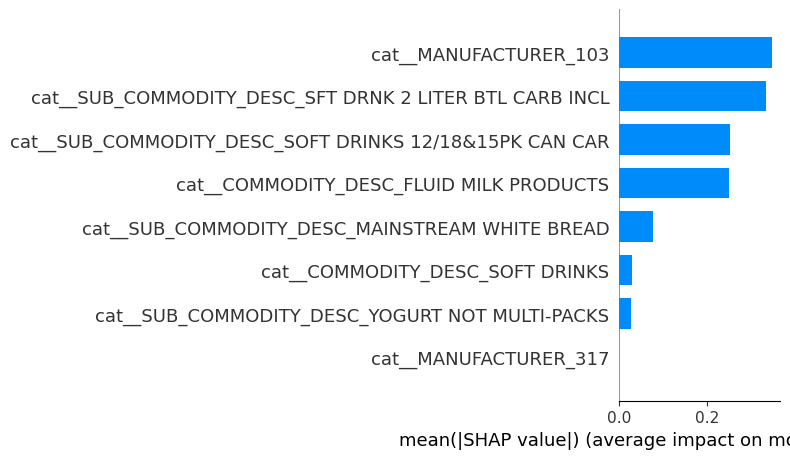

In [6]:
X_encoded_sparse = pipeline.named_steps['preprocessor'].transform(X)
X_encoded_dense = X_encoded_sparse.toarray()  

sample_idx = np.random.choice(X_encoded_dense.shape[0], size=100, replace=False)
X_sample = X_encoded_dense[sample_idx]

explainer = shap.Explainer(pipeline.named_steps['regressor'], X_encoded_dense)

shap_values = explainer(X_sample)

shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(),
    plot_type="bar"
)


In [7]:

shap_df = pd.DataFrame(
    shap_values.values,
    columns=pipeline.named_steps['preprocessor'].get_feature_names_out()
)


shap_df["predicted_price"] = pipeline.named_steps['regressor'].predict(X_sample)
shap_df["actual_price"] = y.iloc[sample_idx].values


shap_df.to_csv("shap_feature_prices.csv", index=False)
print("SHAP feature-level prices saved to 'shap_feature_prices.csv'")

# top contributing features across all samples (mean absolute SHAP)
top_features = shap_df.drop(columns=["predicted_price", "actual_price"]).abs().mean().sort_values(ascending=False).head(10)
print("\nTop contributing features to product price (mean absolute SHAP values):")
print(top_features)


SHAP feature-level prices saved to 'shap_feature_prices.csv'

Top contributing features to product price (mean absolute SHAP values):
cat__MANUFACTURER_103                                     0.347326
cat__SUB_COMMODITY_DESC_SFT DRNK 2 LITER BTL CARB INCL    0.332386
cat__SUB_COMMODITY_DESC_SOFT DRINKS 12/18&15PK CAN CAR    0.251287
cat__COMMODITY_DESC_FLUID MILK PRODUCTS                   0.250073
cat__SUB_COMMODITY_DESC_MAINSTREAM WHITE BREAD            0.075593
cat__COMMODITY_DESC_SOFT DRINKS                           0.029693
cat__SUB_COMMODITY_DESC_YOGURT NOT MULTI-PACKS            0.026175
cat__MANUFACTURER_317                                     0.000000
dtype: float64


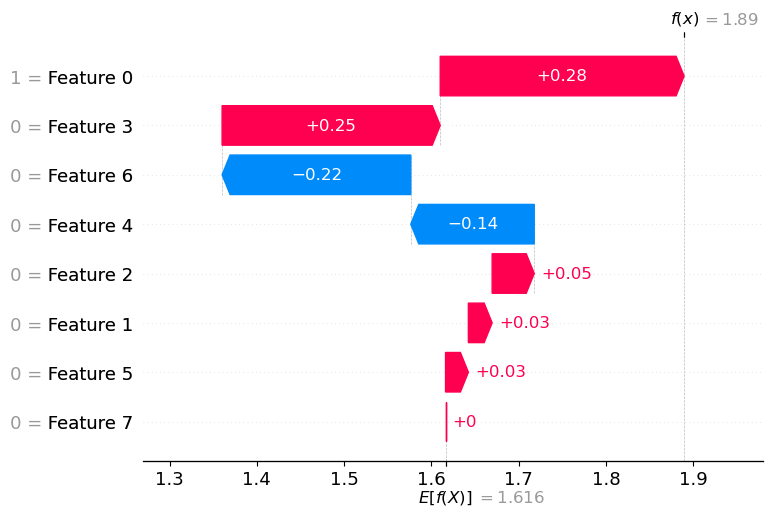

In [8]:
# sample index to explain
i = 0  
shap.plots.waterfall(shap_values[i], max_display=10)


In [9]:
shap.initjs()
shap.force_plot(
    shap_values.base_values[i],
    shap_values.values[i],
    feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out()
)


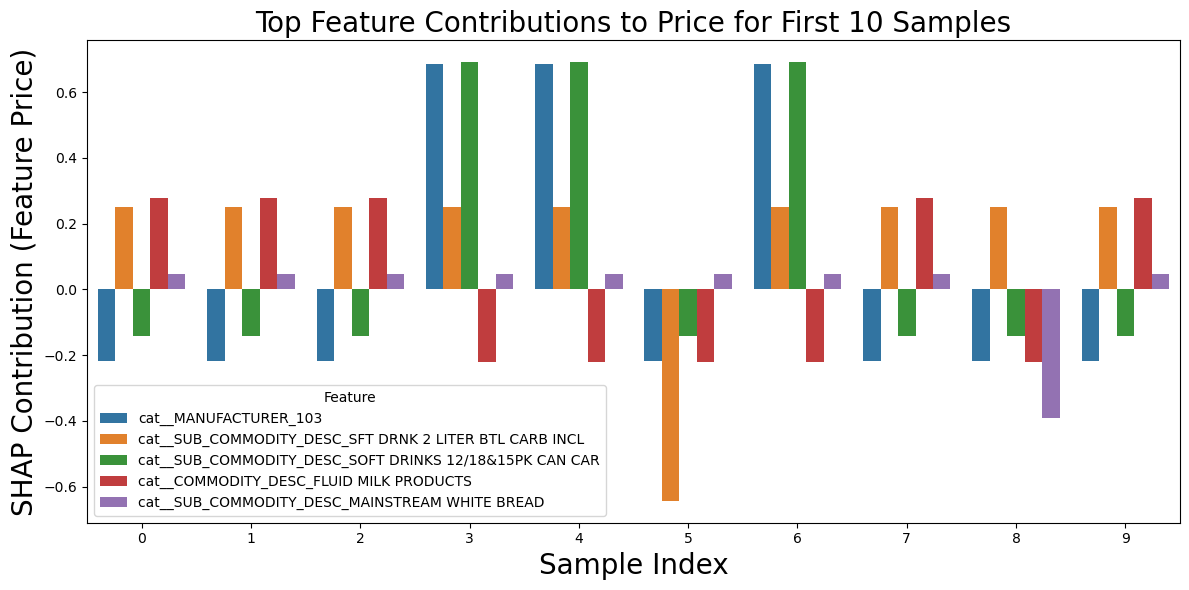

In [11]:
top_feats = shap_df.drop(columns=['predicted_price', 'actual_price']).abs().mean().sort_values(ascending=False).head(5).index

melted = shap_df[top_feats].iloc[:10].reset_index().melt(id_vars='index', var_name='Feature', value_name='Contribution')


plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='Contribution', hue='Feature', data=melted)
plt.title("Top Feature Contributions to Price for First 10 Samples",fontsize=20)
plt.xlabel("Sample Index",fontsize=20)
plt.ylabel("SHAP Contribution (Feature Price)",fontsize=20)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
